In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
cd /content/drive/MyDrive/MA

/content/drive/MyDrive/MA


In [6]:
!pip install transformers==4.2.0
#!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.7-cp36-cp36m-linux_x86_64.whl

     |████████████████████████████████| 1.8MB 8.1MB/s 
     |████████████████████████████████| 2.9MB 37.9MB/s 
     |████████████████████████████████| 890kB 53.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=c2567853fdee890f587391f06ccd3205e5c151d00857891fbdcee334a363fd9c
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [7]:
from transformers import BertForSequenceClassification, DistilBertTokenizerFast, AdamW, get_linear_schedule_with_warmup
import pandas as pd
import torch
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import time
import pickle

In [8]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [9]:
def read_train_and_test(train_path, test_path): #path: path of the whole dataset
  #try:
    train = pd.read_csv(train_path)
    test = pd.read_csv(test_path)
  #except FileNotFoundError:
    #data_csv = pd.read_csv(path, names=['label','tweet'],header=0)
    #train=data_csv.sample(frac=0.8,random_state=200) #random state is a seed value
    #test=data_csv.drop(train.index)
    #train.to_csv('train.csv')
    #test.to_csv('test.csv')
    return train, test

train_path = "./train_tag.csv"
test_path = "./test_tag.csv"
train_csv, test_csv = read_train_and_test(train_path, test_path)

In [ ]:
train_labels = list(train_csv.label.values)
print(train_labels.count(0))
print(train_labels.count(1))

1136
15369


In [10]:
print(train_csv.tweet.values[:50])

['# anywere & # 8220 ; @ TheCooleyShow : LA = palm trees and great weather Any were else = horrible weather and no <SWEAR-NN> & # 8221 ;'
 'RT @ OfficialA1King : The face you make when you see a <SWEAR-NN> trying to preach on twitter http : //t.co/2T1UkUDQBw'
 '<SWEAR-NN> get off my twitter <SWEAR-NN> & # 128074 ;'
 'I can taste loud n <SWEAR-NN> on my <SWEAR-VBP> & # 128541 ;'
 'Diabetes galore & # 128514 ; & # 128514 ; & # 128514 ; & # 128514 ; & # 128514 ; RT @ TIME : Colorado health officials recommend <SWEAR-NN> brownie ban http : //t.co/Z59oy20TMp'
 '@ LaneBelgarde @ A7XDemery you <SWEAR-JJ> <SWEAR-NN> didnt even invite me'
 'RT @ djMemphis10 : Never hurt your Girlfriend to make a <SWEAR-NN> happy & # 128175 ; # djmemphis10'
 'This is why nothing gets done . <SWEAR-NNP> like Coburn trying 2 ad a <SWEAR-NN> amendment 2 a public works bill . Push back on the # teabagger # morningjoe'
 'RT @ ccancel14 : Miserable <SWEAR-NN> talk the most <SWEAR-VBD> & # 128514 ; & # 9996 ; & # 65039

In [ ]:
def run_tokenizer(train_csv, test_csv, merge_label=False, add_token=False):
    tokenizer = DistilBertTokenizerFast.from_pretrained('bert-base-uncased') 
    if add_token:
      tokenizer.add_tokens(add_token)

    def get_max_len(tokenizer, train_csv):
        tweets = train_csv.tweet.values
        max_length = 0
        for t in tweets:
          ids = tokenizer.encode(t)
          max_length = max(len(ids),max_length)
        return max_length

    max_length = get_max_len(tokenizer, train_csv)
    train_tweets, train_labels = train_csv.tweet.values, train_csv.label.values
    test_tweets, test_labels = test_csv.tweet.values, test_csv.label.values
    if merge_label == True:
       train_labels = [l if l ==0 else 1 for l in train_labels]
       test_labels = [l if l ==0 else 1 for l in test_labels]

    def tokenize_for_tweet(tokenizer, tweets, labels):
        input_ids = []
        attention_masks = []

        for t in tweets:
            input_dict = tokenizer.encode_plus(t, add_special_tokens=True, max_length=max_length, truncation=True, padding='max_length',return_tensors='pt')
            input_ids.append(input_dict['input_ids'])
            attention_masks.append(input_dict['attention_mask'])
        input_ids = torch.cat(input_ids,dim=0)
        attention_masks = torch.cat(attention_masks,dim=0)
        labels=torch.tensor(labels)
        dataset = TensorDataset(input_ids, attention_masks, labels)
        return dataset
        
    train_dataset = tokenize_for_tweet(tokenizer, train_tweets, train_labels)
    test_dataset = tokenize_for_tweet(tokenizer, test_tweets, test_labels)
    num_label = 3 if merge_label == False else 2
    return train_dataset, test_dataset, num_label, tokenizer

tokens = ['<SWEAR-RBR>', '<SWEAR-VBN>', '<SWEAR-VB>', '<SWEAR-VBG>', '<SWEAR-IN>', '<SWEAR-JJR>', '<SWEAR-NN>', '<SWEAR-RB>', '<SWEAR-WP>', '<SWEAR-PRP$>', '<SWEAR-NNP>', '<SWEAR-VBP>', '<SWEAR-JJ>', '<SWEAR-JJS>', '<SWEAR-FW>', '<SWEAR-VBZ>', '<SWEAR-NNS>', '<SWEAR-VBD>']
train_dataset, test_dataset, num_label, tokenizer = run_tokenizer(train_csv, test_csv, merge_label = True, add_token=tokens)

In [ ]:
batch_size = 10

train_dataloader = DataLoader(train_dataset, sampler = RandomSampler(train_dataset), batch_size = batch_size)

test_dataloader = DataLoader(test_dataset, sampler = SequentialSampler(test_dataset), batch_size = batch_size)

In [ ]:
bert_model = BertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels = num_label)
bert_model.resize_token_embeddings(len(tokenizer))
bert_model = bert_model.to(DEVICE)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing BertForSequenceClassification: ['distilbert.embeddings.word_embeddings.weight', 'distilbert.embeddings.position_embeddings.weight', 'distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias', 'distilbert.transformer.layer.0.attention.q_lin.weight', 'distilbert.transformer.layer.0.attention.q_lin.bias', 'distilbert.transformer.layer.0.attention.k_lin.weight', 'distilbert.transformer.layer.0.attention.k_lin.bias', 'distilbert.transformer.layer.0.attention.v_lin.weight', 'distilbert.transformer.layer.0.attention.v_lin.bias', 'distilbert.transformer.layer.0.attention.out_lin.weight', 'distilbert.transformer.layer.0.attention.out_lin.bias', 'distilbert.transformer.layer.0.sa_layer_norm.weight', 'distilbert.transformer.layer.0.sa_layer_norm.bias', 'distilbert.transformer.layer.0.ffn.lin1.weight', 'distilbert.transformer.layer.0.ffn.lin1.bias', 'distilbert.transformer.layer.0.

In [ ]:
def evaluate(model, best_acc, test_dataloader):
    num_total, num_correct = 0, 0
    model.train(False)
    with torch.no_grad():
      eval_loss = 0

      for input, mask, label in test_dataloader:
          model.zero_grad()
          
          input = input.to(DEVICE)
          mask = mask.to(DEVICE)
          label = label.to(DEVICE)

          loss, output = model(input_ids=input, attention_mask=mask, labels=label, return_dict=False)

          predict_label = torch.argmax(output, dim=1)

          num_correct += (predict_label == label).sum().item()
          num_total += len(label)

          eval_loss += loss.item()

      acc = num_correct/num_total
      if acc > best_acc:
        best_acc = acc
        torch.save(model, 'model'+str(best_acc))

    print('eval_loss: {}, accuracy: {}'.format(eval_loss,acc))
    return best_acc


In [ ]:
def training(model, epochs, optimizer, train_dataloader, test_dataloader, scheduler=None):
    best_acc = 0
    for e in range(epochs):
        print('training {} epoch...'.format(e+1))
        start_time = time.time()

        train_loss =0

        model.train(True)
        for input, mask, label in train_dataloader:
            input = input.to(DEVICE)
            mask = mask.to(DEVICE)
            label=label.to(DEVICE)
            
            model.zero_grad()

            loss, output = model(input_ids=input, attention_mask=mask, labels=label,return_dict=False)

            train_loss += loss.item()
            loss.backward()

            #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    
            optimizer.step()

            if scheduler:
              scheduler.step()

        sec = time.time()-start_time
        print('{} seconds used......'.format(sec))
        print("{} training finished! train loss: {}".format(e+1,train_loss))
        print('evaluating...')
        best_acc = evaluate(model, best_acc, test_dataloader)

In [ ]:
optimizer = AdamW(bert_model.parameters(),lr = 2e-5, eps = 1e-8)

In [ ]:
epochs = 10

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

NameError: ignored

In [ ]:
training(bert_model, epochs, optimizer, train_dataloader, test_dataloader)

training 1 epoch...
1067.0226707458496 seconds used......
1 training finished! train loss: 445.28407339099795
evaluating...
eval_loss: 112.90811794251204, accuracy: 0.9406899334274763
training 2 epoch...


KeyboardInterrupt: ignored

In [ ]:
def predicting_labels(model, test_dataloader):
    true_labels, predict_labels = [], []
    for input, mask, label in test_dataloader:
        model.zero_grad()
        input=input.to(DEVICE)
        mask=mask.to(DEVICE)
        label=label.to(DEVICE)
        loss, logits = model(input_ids=input, attention_mask=mask, labels=label, return_dict=False)
        predict_label = torch.argmax(logits, dim=1)
        true_labels+=(label.tolist())
        predict_labels+=(predict_label.tolist())
    return true_labels, predict_labels

In [ ]:
model = torch.load('./model_with_tags')
true_labels, predict_labels = predicting_labels(model, test_dataloader)

In [ ]:
accuracy=accuracy_score(true_labels,predict_labels)
print(accuracy)
pre, re, f1, sup = precision_recall_fscore_support(true_labels,predict_labels)
print(pre,re,f1,sup)

0.6945733306435344
[0.12392109 0.97211394] [0.68367347 0.69526056] [0.20981211 0.81070268] [ 294 4663]


In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
import numpy as np
import random

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[ 201   93]
 [1421 3242]]
Normalized confusion matrix
[[0.68367347 0.31632653]
 [0.30473944 0.69526056]]


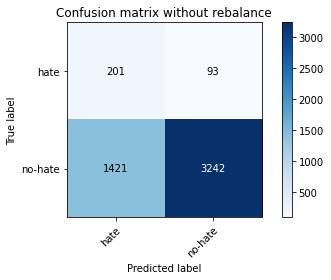

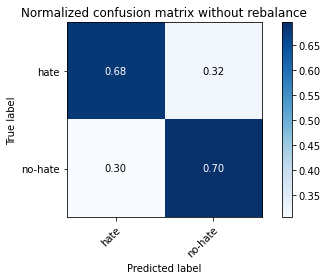

              precision    recall  f1-score   support

        hate       0.12      0.68      0.21       294
     no-hate       0.97      0.70      0.81      4663

    accuracy                           0.69      4957
   macro avg       0.55      0.69      0.51      4957
weighted avg       0.92      0.69      0.78      4957



In [ ]:
cm = confusion_matrix(true_labels, predict_labels)
plot_confusion_matrix(true_labels, predict_labels, classes=['hate','no-hate'] ,title='Confusion matrix without rebalance')

#Plot normalized confusion matrix
plot_confusion_matrix(true_labels, predict_labels, classes=['hate','no-hate'], normalize=True,title='Normalized confusion matrix without rebalance')

plt.show()

print(classification_report(true_labels, predict_labels, target_names=['hate','no-hate']))

In [ ]:
def rebalance_dataset(dataset):
    dataset = sorted(dataset, key=lambda x:x[2])
    num_label_1 = len([inst for inst in dataset if inst[2]==1])
    num_label_0 = len([inst for inst in dataset if inst[2]==0]) 
    balanced_dataset = dataset[:num_label_0] + dataset[num_label_1:num_label_0 + num_label_1]
    random.shuffle(balanced_dataset)
    return balanced_dataset

In [ ]:
re_train_dataset = rebalance_dataset(train_dataset)
re_test_dataset = rebalance_dataset(test_dataset)

In [ ]:
batch_size = 10

In [ ]:
re_train_dataloader = DataLoader(re_train_dataset, sampler = RandomSampler(re_train_dataset), batch_size = batch_size)
re_test_dataloader = DataLoader(re_test_dataset, sampler = RandomSampler(re_test_dataset), batch_size = batch_size)

In [ ]:
training(bert_model, epochs, optimizer, re_train_dataloader, re_test_dataloader)

training 1 epoch...
206.71202850341797 seconds used......
1 training finished! train loss: 164.05433332920074
evaluating...
eval_loss: 40.50473576784134, accuracy: 0.5833333333333334
training 2 epoch...
208.40388226509094 seconds used......
2 training finished! train loss: 151.6862117499113
evaluating...
eval_loss: 38.52282711863518, accuracy: 0.6139455782312925
training 3 epoch...
208.16389107704163 seconds used......
3 training finished! train loss: 135.2588666677475
evaluating...
eval_loss: 35.60651686787605, accuracy: 0.7023809523809523
training 4 epoch...
208.18723106384277 seconds used......
4 training finished! train loss: 127.88322208821774
evaluating...
eval_loss: 36.143621534109116, accuracy: 0.6904761904761905
training 5 epoch...
208.42523765563965 seconds used......
5 training finished! train loss: 118.23350869119167
evaluating...
eval_loss: 39.94794249534607, accuracy: 0.6649659863945578
training 6 epoch...
207.91235518455505 seconds used......
6 training finished! train l

In [ ]:
model2 = torch.load('./model0.7023809523809523')
true_labels2, predict_labels2 = predicting_labels(model2, re_test_dataloader)

In [ ]:
accuracy2=accuracy_score(true_labels2,predict_labels2)
print(accuracy2)
pre2, re2, f1_2, sup2 = precision_recall_fscore_support(true_labels2,predict_labels2)
print(pre2,re2,f1_2,sup2)

0.7023809523809523
[0.71024735 0.69508197] [0.68367347 0.72108844] [0.69670711 0.70784641] [294 294]


Confusion matrix, without normalization
[[201  93]
 [ 82 212]]
Normalized confusion matrix
[[0.68367347 0.31632653]
 [0.27891156 0.72108844]]


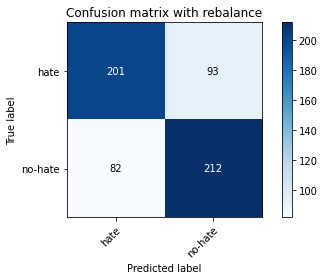

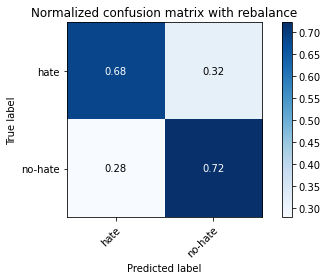

              precision    recall  f1-score   support

        hate       0.71      0.68      0.70       294
     no-hate       0.70      0.72      0.71       294

    accuracy                           0.70       588
   macro avg       0.70      0.70      0.70       588
weighted avg       0.70      0.70      0.70       588



In [ ]:
cm = confusion_matrix(true_labels2, predict_labels2)
plot_confusion_matrix(true_labels2, predict_labels2, classes=['hate','no-hate'] ,title='Confusion matrix with rebalance')

#Plot normalized confusion matrix
plot_confusion_matrix(true_labels2, predict_labels2, classes=['hate','no-hate'], normalize=True,title='Normalized confusion matrix with rebalance')

plt.show()

print(classification_report(true_labels2, predict_labels2, target_names=['hate','no-hate']))